# Projet Machine Learning - Pump it Up Data Mining the Water Table

Using data from Taarifa and the Tanzanian Ministry of Water, the goal is to predict which pumps are functional, which need some repairs, and which are not functionnal at all.
Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

## I - Packages and input data

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

from codes.map_design import displayMap
from codes.predicteurs import Predict
from codes.unbalanced_predictions import unbalancedPrediction
from codes.getExtraData import regions_list, url_regions, get_label_climat_region

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/map_design.py:11: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('TkAgg')


In [2]:
path = os.getcwd()

# Import des données
train_set = pd.read_csv(path + '/data/training_set_values.csv', sep=',')
test_set = pd.read_csv(path + '/data/test_set_values.csv', sep=',')
train_labels = pd.read_csv(path + '/data/training_set_labels.csv', sep=',')

In [3]:
# Check the size of datasets
print('Train set shape:', train_set.shape)
print('Train labels shape:', train_labels.shape)
print('Test set shape:', test_set.shape)

Train set shape: (59400, 40)
Train labels shape: (59400, 2)
Test set shape: (14850, 40)


## II - Display the pump repartition on the Tanzanian map

(Using the class displayMap)

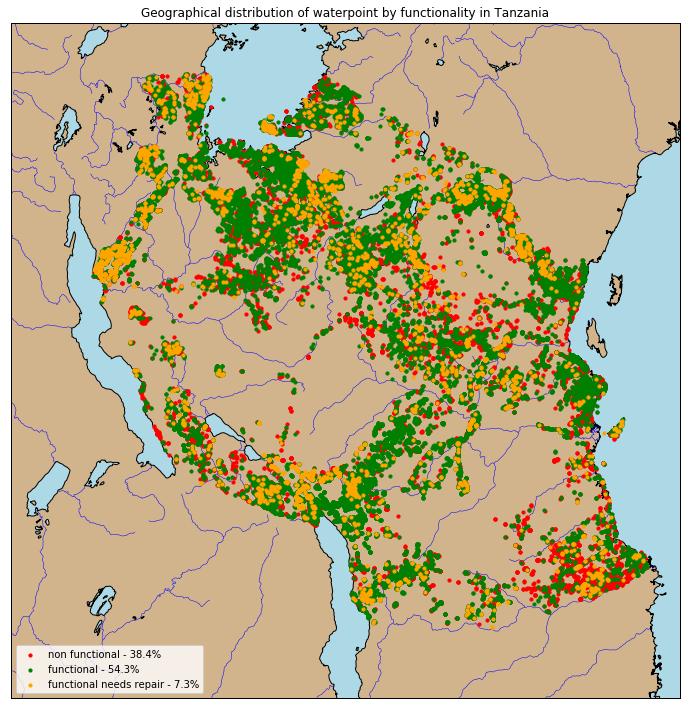

In [4]:
# Display the map
data = pd.merge(train_set, train_labels, how='inner')
map_water_pumps = displayMap(data, 'status_group')
map_water_pumps.display_map()
plt.show()

## III - Scrapp extra data

(from climate-data.org)

In [5]:
climat_infos_region = get_label_climat_region(regions_list, url_regions)

In [6]:
climat_infos_region.head()

,region,label_climat_reg
0,arusha,Csb
1,dar es salaam,Aw
2,dodoma,BSh
3,geita,Aw
4,iringa,Csb


In [7]:
# Merge the data
# train set
train_set['region'] = train_set['region'].apply(lambda x: x.lower())
# infos regions
train_set = train_set.merge(climat_infos_region, on='region', how='left')

# test set
test_set['region'] = test_set['region'].apply(lambda x: x.lower())
test_set = test_set.merge(climat_infos_region, on='region', how='left')

## IV - Exploratory Data Analysis 

Functionnal:  54.31
Non-Functionnal:  38.42
Functional needs repair:  7.27


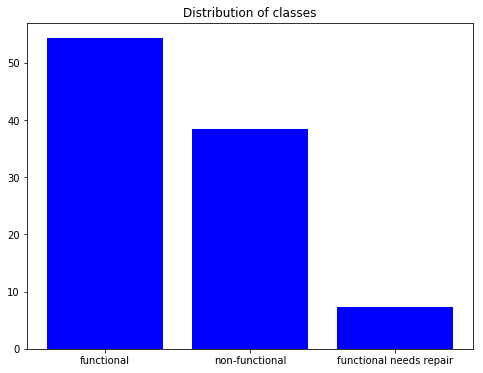

In [8]:
# Distribution of classes
legend = ['functional', 'non-functional', 'functional needs repair']
x = np.arange(len(train_labels['status_group'].unique()))
distrib = [round(train_labels[train_labels['status_group'] == x]['status_group'].count()/len(train_labels)*100,2)
           for x in train_labels['status_group'].unique()]

# List of distribution 
print('Functionnal: ', distrib[0])
print('Non-Functionnal: ', distrib[1])
print('Functional needs repair: ', distrib[2])

# Plot dsitribution as barplot
plt.figure(figsize=(8, 6))
plt.bar(x, distrib, color = 'blue')
plt.xticks(x, legend)
plt.title('Distribution of classes')
plt.show()

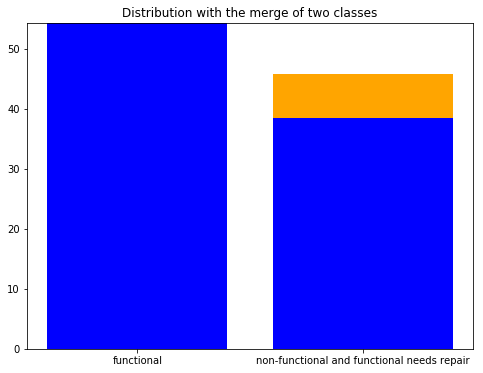

In [9]:
# Merge both under-represented classes
N = np.arange(2)
legend = ['functional', 'non-functional and functional needs repair']

distrib_1 = [round(train_labels[train_labels['status_group'] == x]['status_group'].count()/len(train_labels)*100,2)
             for x in ['functional', 'non functional']]
distrib_2 = [0, round(train_labels[train_labels['status_group'] == 'functional needs repair']['status_group'].count()/len(train_labels)*100,2)]

# Plot new distrib
plt.figure(figsize=(8, 6))
plt.bar(N, distrib_1, color = 'blue')
plt.bar(N, distrib_2, color = 'orange', bottom = distrib_1)
plt.xticks(N, legend)
plt.title('Distribution with the merge of two classes')
plt.show()

### A - Missing values study

In [10]:
# Features with missing data
missing = train_set.apply(lambda x: x.isnull().sum(), axis = 0)
missing = pd.DataFrame(missing)
missing.columns = ["Number of missing values"]


# Keep only features with missing data
missing = missing[missing['Number of missing values'] != 0]
missing['Share'] = round(missing['Number of missing values']/np.sum(missing['Number of missing values'])*100,2)
missing = missing.sort_values(by=['Share'], ascending=False)
print(missing)
print(missing.index)

                   Number of missing values  Share
scheme_name                           28166  61.11
scheme_management                      3877   8.41
installer                              3655   7.93
funder                                 3635   7.89
public_meeting                         3334   7.23
permit                                 3056   6.63
subvillage                              371   0.80
Index(['scheme_name', 'scheme_management', 'installer', 'funder',
       'public_meeting', 'permit', 'subvillage'],
      dtype='object')


In [11]:
nb_total_missing = np.sum(missing['Number of missing values'])
nb_total_missing
train_set.shape
share_missing_total = nb_total_missing/(train_set.shape[0]*train_set.shape[1])
share_missing_total*100

1.8926665024226

In [12]:
list_missing = list(missing.index)
list_missing

['scheme_name',
 'scheme_management',
 'installer',
 'funder',
 'public_meeting',
 'permit',
 'subvillage']

scheme_name


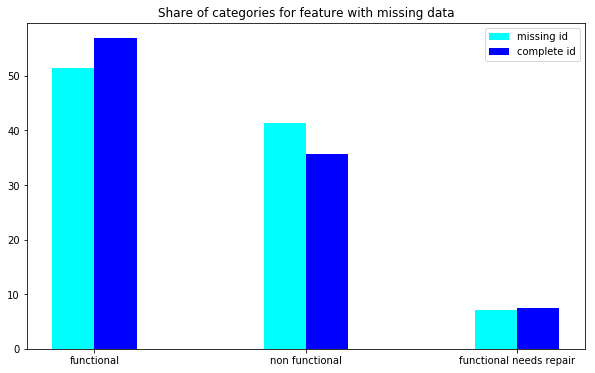

scheme_management


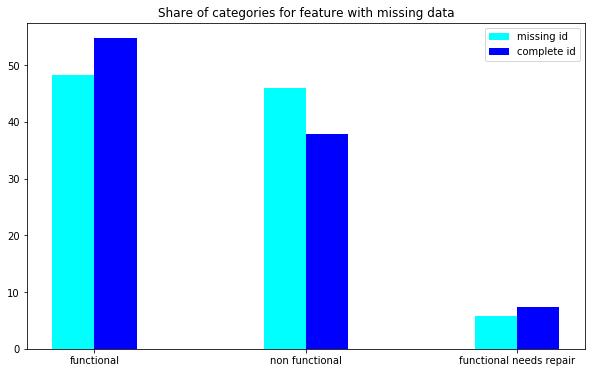

installer


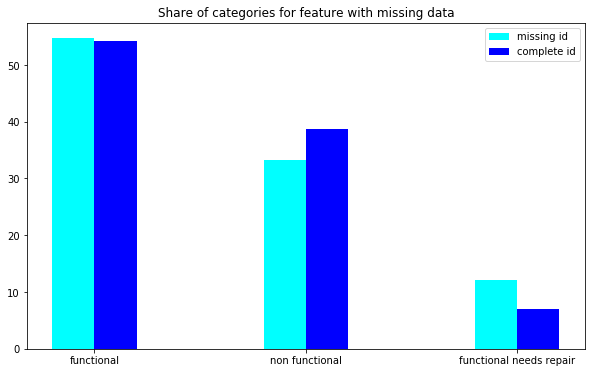

funder


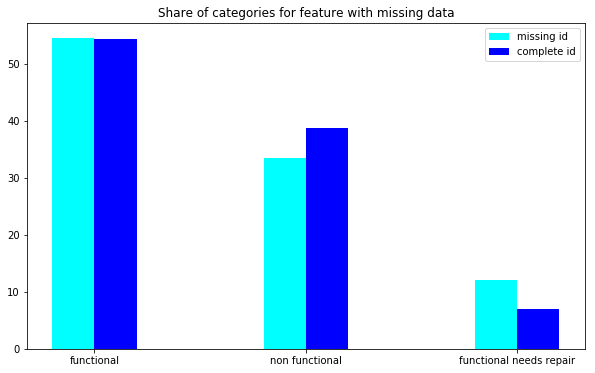

public_meeting


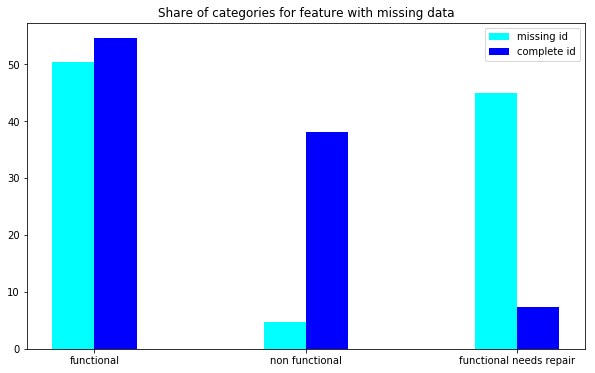

permit


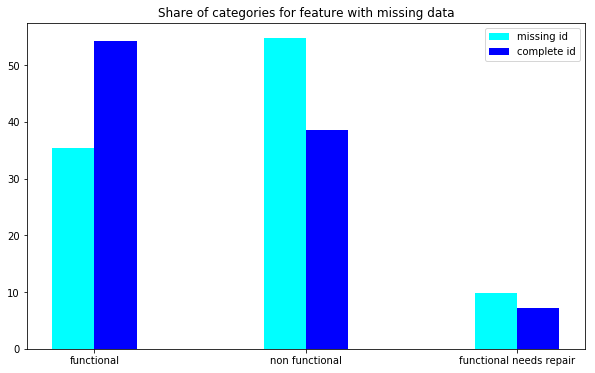

subvillage


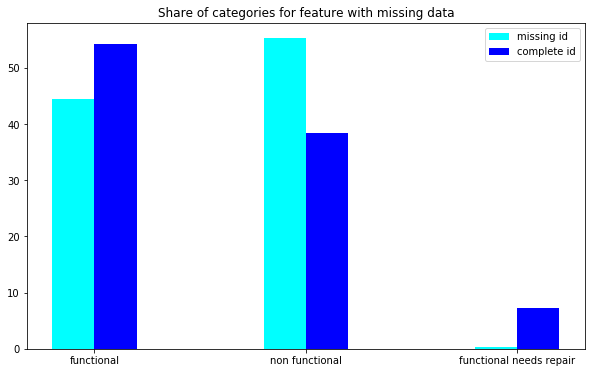

In [13]:
# Plot distribution by feature which belongs to 'list_missing'
train = pd.merge(train_set, train_labels, how='inner')
x = train['status_group'].unique()
legend = ['missing id', 'complete id']
N = np.arange(1, 4)
ecart = 0.1
N_1 = N - ecart
N_2 = N + ecart
for features in list_missing:
    isolate_1 = train[train[features].isnull() == True]
    isolate_2 = train[train[features].isnull() == False]
    count_1 = len(isolate_1)
    count_2 = len(isolate_2)
    share_1 = [round((isolate_1[isolate_1['status_group'] == x]['id'].count()/count_1)*100,2) for x in isolate_1['status_group'].unique()]
    share_2 = [round((isolate_2[isolate_2['status_group'] == x]['id'].count()/count_2)*100,2) for x in isolate_2['status_group'].unique()]
    plt.figure(figsize = (10,6))
    print(features)
    plt.bar(N_1, share_1,width= 0.2, color = 'cyan')
    plt.bar(N_2, share_2, width= 0.2, color = 'blue')
    plt.xticks(N, x)
    plt.title('Share of categories for feature with missing data')
    plt.legend(legend)
    plt.show()

Looking at shares of classes as percentage of missing values, we conclude missing vales might be relevant to detect pump with a status 'functional needs repair'.

### B - Categorical data study

In [14]:
train_set['density_population'] = train_set['population']/np.sum(train_set['population'])
test_set['density_population'] = test_set['population']/np.sum(test_set['population'])

# Which variable are categorical and which one are numerical
test_variable_float = np.float64(2)
test_variable_int = np.int64(1)

categorical = list()
numerical = list()

for x in train_set.columns:
    if (type(train_set[x].iloc[1]) == type(test_variable_float) or
       type(train_set[x].iloc[1]) == type(test_variable_int)):
        numerical.append(x)
    else:
        categorical.append(x)

print('Categorical variables:', len(categorical))
print(categorical)
print()
print('Numerical variables:', len(numerical))
print(numerical)

Categorical variables: 31
['date_recorded', 'funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'lga', 'ward', 'public_meeting', 'recorded_by', 'scheme_management', 'scheme_name', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'label_climat_reg']

Numerical variables: 11
['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'density_population']


In [15]:
# How many categorical ?
print('Number of categorical variables:', len(categorical))
# How many numerical ?
print('Number of numerical variables:', len(numerical))

Number of categorical variables: 31
Number of numerical variables: 11


#### Merge the train and test set so as to have the same treatment

In [16]:
train_set_index = train_set.index
test_set_index = test_set.index
data = pd.concat([train_set, test_set])

In [17]:
data_categ = data[categorical]
data_categ.head()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,label_climat_reg
0,2011-03-14,Roman,Roman,none,Lake Nyasa,Mnyusi B,iringa,Ludewa,Mundindi,True,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,Csb
1,2013-03-06,Grumeti,GRUMETI,Zahanati,Lake Victoria,Nyamara,mara,Serengeti,Natta,NaN,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Aw
2,2013-02-25,Lottery Club,World vision,Kwa Mahundi,Pangani,Majengo,manyara,Simanjiro,Ngorika,True,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,Csb
3,2013-01-28,Unicef,UNICEF,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,mtwara,Nanyumbu,Nanyumbu,True,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,Aw
4,2011-07-13,Action In A,Artisan,Shuleni,Lake Victoria,Kyanyamisa,kagera,Karagwe,Nyakasimbi,True,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,Aw


#### Study of the number of categories within each variables : threshold approach

Nb: date_recorded will be our reference to evaluate the repartition of the categories within each variable since there is no missing values.

In [18]:
# Apply this method for all categorical variables
j = 1
for categ in categorical:
    if categ != 'date_recorded':
        temp = data_categ[[categ, 'date_recorded']]
        cat_var = temp.groupby([categ], as_index=False)['date_recorded'].count()

        cat_var.columns = [categ, 'count']
        cat_var['repartition_percent'] = cat_var['count']/np.sum(cat_var['count'])*100
        cat_var = cat_var.sort_values(by=['count'], ascending=False)
        cat_var.reset_index(inplace=True)
        
        # Visualize the 10 first (max) classes represented
        index_visualize = min(cat_var.shape[0], 10)
        cat_var_10_first = cat_var.loc[np.arange(0, index_visualize)]
        
        # Visualize the repartition taken the other classes as other
        var_retain = list(cat_var_10_first[categ])
        cat_var2 = cat_var[[categ, 'count']]
        cat_var2[categ] = cat_var2[categ].apply(lambda x: x if x in var_retain else 'other')
        cat_var2 = cat_var2.groupby([categ], as_index=False)['count'].sum()
        cat_var2['repartition_percent'] = cat_var2['count']/np.sum(cat_var2['count'])*100
        cat_var2 = cat_var2.sort_values(by=['count'], ascending=False)
    
        # Nb of different categories
        print('Categorical variable ' + str(j) + ':', categ)
        print('----')
        print('Number of categories initially:', cat_var.shape[0])
        print('\n---- 10 first categories represented')
        print(cat_var_10_first)
        print('\n---- Result if other assigned to all the other categories')
        print(cat_var2)
        print('')
        
        j += 1
        

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Categorical variable 1: funder
----
Number of categories initially: 2140

---- 10 first categories represented
   index                  funder  count  repartition_percent
0    507  Government Of Tanzania  11299            16.200212
1    293                  Danida   3907             5.601755
2    573                  Hesawa   2782             3.988759
3   1599                   Rwssp   1703             2.441717
4   2106              World Bank   1701             2.438850
5    808                    Kkkt   1623             2.327015
6   2108            World Vision   1562             2.239555
7   1961                  Unicef   1324             1.898317
8   1841                   Tasaf   1136             1.628767
9    327                     Dhv   1065             1.526969

---- Result if other assigned to all the other categories
                    funder  count  repartition_percent
10                   other  41644            59.708084
2   Government Of Tanzania  11299            16.2

Categorical variable 10: recorded_by
----
Number of categories initially: 1

---- 10 first categories represented
   index              recorded_by  count  repartition_percent
0      0  GeoData Consultants Ltd  74250                100.0

---- Result if other assigned to all the other categories
               recorded_by  count  repartition_percent
0  GeoData Consultants Ltd  74250                100.0

Categorical variable 11: scheme_management
----
Number of categories initially: 12

---- 10 first categories represented
   index scheme_management  count  repartition_percent
0      7               VWC  45917            66.159011
1      9               WUG   6496             9.359691
2     11   Water authority   3975             5.727336
3      8               WUA   3551             5.116420
4     10       Water Board   3462             4.988185
5      3        Parastatal   2124             3.060342
6      0           Company   1341             1.932165
7      4  Private operator   13

Categorical variable 18: management_group
----
Number of categories initially: 5

---- 10 first categories represented
   index management_group  count  repartition_percent
0      4       user-group  65538            88.266667
1      0       commercial   4591             6.183165
2      2       parastatal   2229             3.002020
3      1            other   1209             1.628283
4      3          unknown    683             0.919865

---- Result if other assigned to all the other categories
  management_group  count  repartition_percent
4       user-group  65538            88.266667
0       commercial   4591             6.183165
2       parastatal   2229             3.002020
1            other   1209             1.628283
3          unknown    683             0.919865

Categorical variable 19: payment
----
Number of categories initially: 7

---- 10 first categories represented
   index                payment  count  repartition_percent
0      0              never pay  31712       

Categorical variable 30: label_climat_reg
----
Number of categories initially: 3

---- 10 first categories represented
   index label_climat_reg  count  repartition_percent
0      0               Aw  56253            75.761616
1      2              Csb  12682            17.080135
2      1              BSh   5315             7.158249

---- Result if other assigned to all the other categories
  label_climat_reg  count  repartition_percent
0               Aw  56253            75.761616
2              Csb  12682            17.080135
1              BSh   5315             7.158249



### Missing values Analysis

cf previous part.

### Categorical Analysis

The previous study allows us to choose whether the categorical variable is relevant for our study or not. In fact, if the categorical variable shows a significant percentage of "other" category, we can state on the unrelevance of the aforementionned variable. Furthemore, if a categorical variable contains a huge amount of categories, we can also consider the variable as not relevant.

Moreover, some variables are contained in other variables such as:
- 'wpt_name' and 'subvillage' are contained in the variable 'longitude' and 'latitude'.
- extraction_type_group, extraction_type_class are contained in extraction_type
- etc ...

Finally, the variable 'recorded_by' contains only one category.

### Final choice

Therefore, we choose to keep for our study the following variables: ( var (nb_categories) )
- installer : Choice DWE and Other
- basin (9)
- region (21)
- public_meeting (2) : Missing values analysis shows this variable is discriminant. Creation of a                                        subcategory 'missing' which contains a lot of 'needs to repair' labels.
- scheme_management (12)
- permit (2) : Missing values analysis shows this variable is discriminant. Creation of a                                        subcategory 'missing'.
- extraction_type (18)
- management (12)
- payment (7)
- water_quality (8)
- quality_group (6) 
- quantity (5)
- source (10)
- waterpoint_type (7)
- label_climat_reg (3)


In [19]:
categorical_selected = ['installer', 'basin', 'region', 'public_meeting', 'scheme_management',
                        'permit', 'extraction_type', 'management', 'payment', 'water_quality',
                       'quality_group', 'quantity', 'source', 'waterpoint_type', 'label_climat_reg']

#### Management of the categorical variables which contains nan and/or relevant information

In [20]:
# installer
data['installer'] = data['installer'].apply(lambda x: x if x == 'DWE' else 'other')

# public_meeting
data['public_meeting'] = data['public_meeting'].fillna('missing')

# permit
data['permit'] = data['permit'].fillna('missing')

# scheme_management
data['scheme_management'] = data['scheme_management'].fillna('missing')

#### One Hot encoder for categorical variables

In [21]:
# select the proper dataset
data_selected = data[categorical_selected]
data_selected[numerical] = data[numerical]

# One hot encoder for categorical variables
data_selected = pd.get_dummies(data_selected)

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


#### Label encoder

In [22]:
# Label encoder
code = LabelEncoder()
code.fit(['functional', 'non functional', 'functional needs repair'])
train_labels['status_group_labels_encode'] = code.transform(train_labels['status_group'])

#### Merge the datasets and generate the training set

In [23]:
# Generate train et test set
train_set = data_selected.loc[train_set_index]
test_set = data_selected.loc[test_set_index]

In [24]:
# Merge the data
train = pd.merge(train_set, train_labels, how='inner')

In [25]:
print('Train set shape - encoded:', train.shape)
print('Test set shape - encoded:', test_set.shape)

Train set shape - encoded: (59400, 140)
Test set shape - encoded: (29700, 138)


### C - Feature importance

In [26]:
X = train.drop(['status_group', 'status_group_labels_encode'], axis=1).copy()
y = train['status_group_labels_encode'].copy()

In [27]:
print('Shape of X:', X.shape)
print('Shape of y:', y.shape)

Shape of X: (59400, 138)
Shape of y: (59400,)


In [28]:
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(np.array(X), np.array(y))

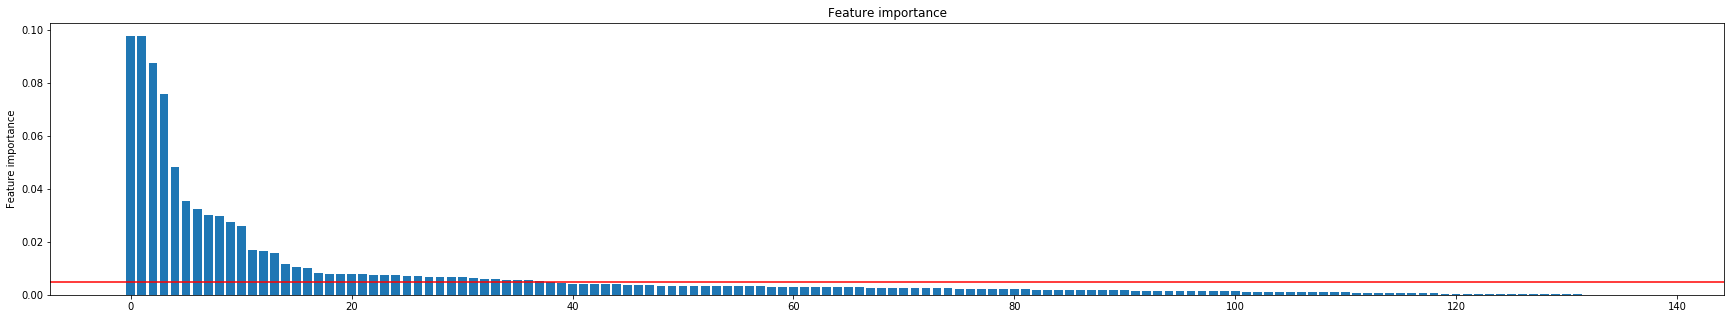

In [29]:
# Limitation for the feature importance
lim_feature_imp = 0.005
labels = X.columns

# Sorted
sort_features = np.argsort(clf.feature_importances_)[::-1]
feature_importance_sorted = clf.feature_importances_[sort_features]
labels_sorted = labels[sort_features]

# Figure
fig = plt.figure(figsize=(30, 5))
plt.bar(np.arange(0, len(clf.feature_importances_)), feature_importance_sorted)
plt.axhline(y=lim_feature_imp, color='r', linestyle='-')
plt.ylabel('Feature importance')
plt.title('Feature importance')
plt.show()

In [30]:
print('Selected labels:')
print(labels_sorted)
print()
print('Nb of labels:', len(labels_sorted))

Selected labels:
Index(['latitude', 'longitude', 'id', 'quantity_dry', 'gps_height',
       'construction_year', 'waterpoint_type_other', 'density_population',
       'population', 'extraction_type_other',
       ...
       'extraction_type_other - play pump', 'extraction_type_walimi',
       'extraction_type_cemo', 'extraction_type_climax',
       'management_other - school', 'scheme_management_SWC',
       'water_quality_fluoride abandoned', 'waterpoint_type_dam',
       'extraction_type_other - mkulima/shinyanga', 'scheme_management_None'],
      dtype='object', length=138)

Nb of labels: 138


In [31]:
# Selection of the variable:
variables_selected = []
for i in range(len(feature_importance_sorted)):
    if feature_importance_sorted[i] > lim_feature_imp:
        variables_selected.append(labels_sorted[i])

print('Variables selected with the feature importance analysis:')
print(variables_selected)
print()
print('Nb of variables selected:', len(variables_selected))

Variables selected with the feature importance analysis:
['latitude', 'longitude', 'id', 'quantity_dry', 'gps_height', 'construction_year', 'waterpoint_type_other', 'density_population', 'population', 'extraction_type_other', 'quantity_enough', 'payment_never pay', 'district_code', 'quantity_insufficient', 'waterpoint_type_communal standpipe', 'amount_tsh', 'waterpoint_type_communal standpipe multiple', 'source_spring', 'installer_other', 'installer_DWE', 'permit_True', 'waterpoint_type_hand pump', 'management_vwc', 'extraction_type_gravity', 'permit_False', 'payment_pay per bucket', 'quantity_seasonal', 'region_code', 'extraction_type_nira/tanira', 'label_climat_reg_Csb', 'payment_unknown', 'scheme_management_VWC', 'public_meeting_True', 'source_machine dbh', 'public_meeting_False', 'source_river', 'payment_pay monthly', 'source_shallow well']

Nb of variables selected: 38


# V - Predictions & Submissions

## V - 1 - Predictions & Submissions - 3 classes problem

In [32]:
# Select the id to submit
submit = pd.read_csv(path + '/data/SubmissionFormat.csv', sep=',')
submit_id = submit['id']
X = pd.concat([train_set, test_set], sort=False)
X = X.drop_duplicates(subset='id')

# Define the dataset to submit
X_submit = X.loc[X['id'].isin(submit_id)]
X_learn = X.loc[~X['id'].isin(submit_id)]
X_learn = pd.merge(X_learn, train_labels, on='id', how='inner')

# Variable selection and definition of the train data
X = X_learn[variables_selected]
y = np.array(X_learn['status_group_labels_encode'])
submit = X_submit[variables_selected]

In [33]:
X.head()

,latitude,longitude,id,quantity_dry,gps_height,construction_year,waterpoint_type_other,density_population,population,extraction_type_other,...,extraction_type_nira/tanira,label_climat_reg_Csb,payment_unknown,scheme_management_VWC,public_meeting_True,source_machine dbh,public_meeting_False,source_river,payment_pay monthly,source_shallow well
0,-9.856322,34.938093,69572,0,1390,1999,0,0.000010,109,0,...,0,1,0,1,1,0,0,0,0,0
1,-2.147466,34.698766,8776,0,1399,2010,0,0.000026,280,0,...,0,0,0,0,0,0,0,0,0,0
2,-3.821329,37.460664,34310,0,686,2009,0,0.000023,250,0,...,0,1,0,1,1,0,0,0,0,0
3,-11.155298,38.486161,67743,1,263,1986,0,0.000005,58,0,...,0,0,0,1,1,1,0,0,0,0
4,-1.825359,31.130847,19728,0,0,0,0,0.000000,0,0,...,0,0,0,0,1,0,0,0,0,0


In [34]:
submit.head()

,latitude,longitude,id,quantity_dry,gps_height,construction_year,waterpoint_type_other,density_population,population,extraction_type_other,...,extraction_type_nira/tanira,label_climat_reg_Csb,payment_unknown,scheme_management_VWC,public_meeting_True,source_machine dbh,public_meeting_False,source_river,payment_pay monthly,source_shallow well
0,-4.059696,35.290799,50785,0,1996,2012,1,0.000117,321,1,...,0,1,0,0,1,0,0,0,0,0
1,-3.309214,36.656709,51630,0,1569,2000,0,0.000110,300,0,...,0,1,0,1,1,0,0,0,0,0
2,-5.004344,34.767863,17168,0,1567,2010,1,0.000183,500,1,...,0,0,0,1,1,0,0,0,0,0
3,-9.418672,38.058046,45559,1,267,1987,1,0.000091,250,1,...,0,0,1,1,0,0,0,0,0,1
4,-10.950412,35.006123,49871,0,1260,2000,0,0.000022,60,0,...,0,0,0,0,0,0,0,0,1,0


In [35]:
print('X shape:', X.shape)
print('y shape:', y.shape)
print('Submit shape:', submit.shape)

X shape: (59400, 38)
y shape: (59400,)
Submit shape: (14850, 38)


#### Normalisation des données

In [36]:
data = pd.concat((X, submit))
col_x = X.columns
col_submit = submit.columns

In [37]:
print(data.shape)

(74250, 38)


In [38]:
scaler = MinMaxScaler()
scaler.fit(data)

X = pd.DataFrame(scaler.transform(X))
X.columns = col_x
submit = pd.DataFrame(scaler.transform(submit))
submit.columns = col_submit

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [39]:
X.head()

,latitude,longitude,id,quantity_dry,gps_height,construction_year,waterpoint_type_other,density_population,population,extraction_type_other,...,extraction_type_nira/tanira,label_climat_reg_Csb,payment_unknown,scheme_management_VWC,public_meeting_True,source_machine dbh,public_meeting_False,source_river,payment_pay monthly,source_shallow well
0,0.153923,0.865979,0.937009,0.0,0.516219,0.993045,0.0,0.002431,0.003574,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.815659,0.860047,0.118197,0.0,0.519358,0.998510,0.0,0.006246,0.009180,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.671973,0.928504,0.462094,0.0,0.270666,0.998013,0.0,0.005577,0.008197,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.042418,0.953922,0.912376,1.0,0.123125,0.986587,0.0,0.001294,0.001902,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.843309,0.771612,0.265701,0.0,0.031392,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [40]:
submit.head()

,latitude,longitude,id,quantity_dry,gps_height,construction_year,waterpoint_type_other,density_population,population,extraction_type_other,...,extraction_type_nira/tanira,label_climat_reg_Csb,payment_unknown,scheme_management_VWC,public_meeting_True,source_machine dbh,public_meeting_False,source_river,payment_pay monthly,source_shallow well
0,0.651511,0.874721,0.683982,0.0,0.727590,0.999503,1.0,0.027988,0.010525,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.715934,0.908577,0.695363,0.0,0.578654,0.993542,0.0,0.026157,0.009836,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.570422,0.861760,0.231222,0.0,0.577956,0.998510,1.0,0.043596,0.016393,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.191491,0.943311,0.613597,1.0,0.124520,0.987084,1.0,0.021798,0.008197,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.060005,0.867665,0.671672,0.0,0.470875,0.993542,0.0,0.005231,0.001967,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Predictions

----
Initialisation - Decision Tree classifier


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


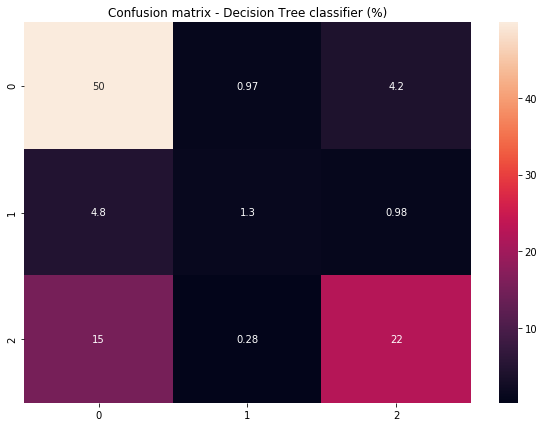

Prediction process completed in 4.96 s

----
Initialisation - Random Forest classifier


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


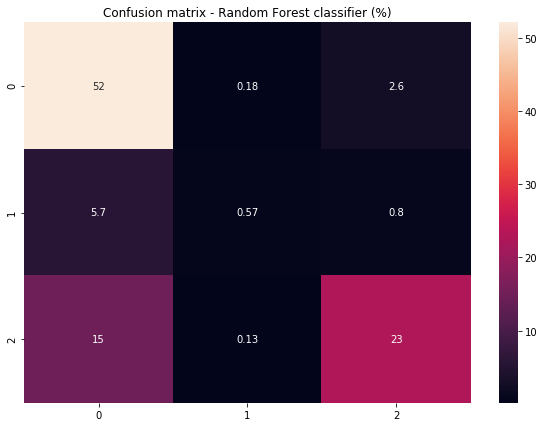

Prediction process completed in 58.1 s

----
Initialisation - Gradient Boosting classifier


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


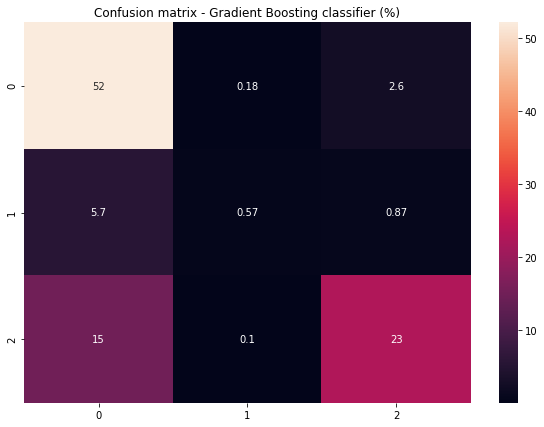

Prediction process completed in 65.69 s

----
Initialisation - XGBoost classifier


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


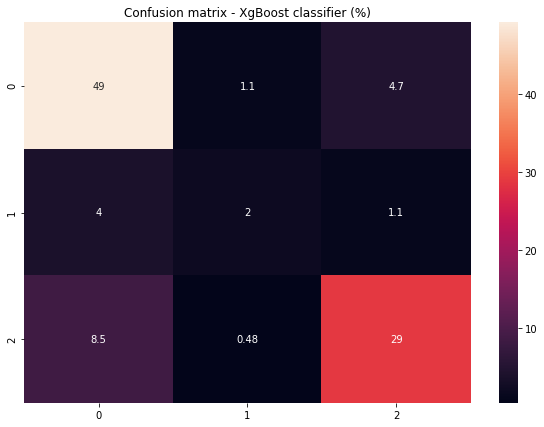

Prediction process completed in 1684.13 s

Execution time: 30.21 min

Score Arbre de décision:  0.7353331292725233
Score RandomForest:  0.754463830221406
Score GradientBoosting:  0.7546678910315274
Score XGBoost:  0.8018569533721049


In [41]:
# Predict
#sm = SMOTE(random_state=2)
#X_sm, y_sm = sm.fit_sample(X, y.ravel())
predicteur = Predict(X, y)

# time
start = time.time()

# Arbre de décision
print('----')
print('Initialisation - Decision Tree classifier')
substart = time.time()
ArbreDecision_predictions = predicteur.make_prediction('ArbreDecision', submit)
subexec_time = np.round(time.time() - substart, 2)
print('Prediction process completed in', subexec_time, 's')
print()

# Random Forest
print('----')
print('Initialisation - Random Forest classifier')
substart = time.time()
RandomForest_predictions = predicteur.make_prediction('RandomForest', submit)
subexec_time = np.round(time.time() - substart, 2)
print('Prediction process completed in', subexec_time, 's')
print()

# Gradient Boosting
print('----')
print('Initialisation - Gradient Boosting classifier')
substart = time.time()
GradientBoosting_predictions = predicteur.make_prediction('GradientBoosting', submit)
subexec_time = np.round(time.time() - substart, 2)
print('Prediction process completed in', subexec_time, 's')
print()

# XGBoost
print('----')
print('Initialisation - XGBoost classifier')
substart = time.time()
XGBoost_predictions = predicteur.make_prediction('XgBoost', submit)
subexec_time = np.round(time.time() - substart, 2)
print('Prediction process completed in', subexec_time, 's')
print()

# Execution time
exec_time = np.round((time.time() - start)/60, 2)
print('Execution time:', exec_time, 'min')
print()

# Scores
print('Score Arbre de décision: ', ArbreDecision_predictions[1])
print('Score RandomForest: ', RandomForest_predictions[1])
print('Score GradientBoosting: ', GradientBoosting_predictions[1])
print('Score XGBoost: ', XGBoost_predictions[1])

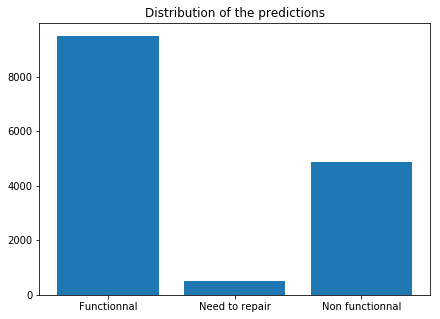

In [42]:
# Distribution of the predictions of the best predictor
pred = XGBoost_predictions[0]
pred = [np.sum(pred==0), np.sum(pred==1), np.sum(pred==2)]
labels = ['Functionnal', 'Need to repair', 'Non functionnal']
plt.figure(figsize=(7, 5))
plt.bar(np.arange(0, 3), pred)
plt.xticks(np.arange(0, 3), labels)
plt.title('Distribution of the predictions')
plt.show()

### Submissions

In [43]:
# Prediction of the dataset - Submit
path_submit = path + '/submissions'

# Best model
to_submit = pd.DataFrame()
to_submit['id'] = X_submit['id']
to_submit['status_group'] = code.inverse_transform(XGBoost_predictions[0])
# CSV
to_submit.to_csv(path_submit + '/Submissions_xgboost.csv', sep=",",
                 header=True, index=False)

## V - 2 - Predictions & Submissions - 2/2 classes problem

### Predictions

----
Initialisation - Decision Tree classifier
2 classes approach:
----
Step 1:
predicting class 0 and class 1 (i.e class 1 and 2)


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


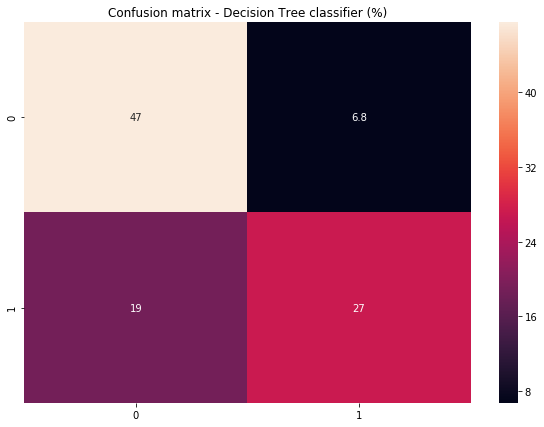

Step 2:
predicting class 1 or 2 within class 1


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


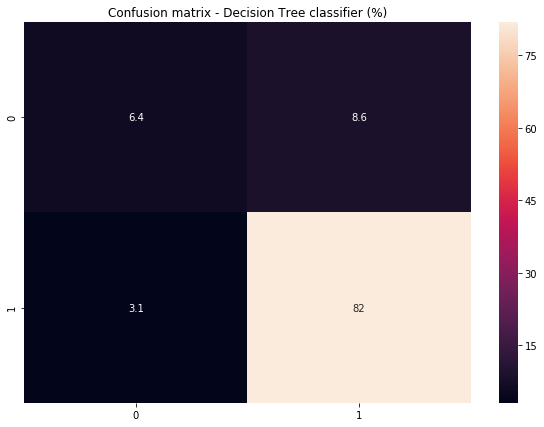

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/unbalanced_predictions.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_temp['Class 2'] = y2_score


Prediction process completed in 9.24 s

----
Initialisation - Random Forest classifier
2 classes approach:
----
Step 1:
predicting class 0 and class 1 (i.e class 1 and 2)


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


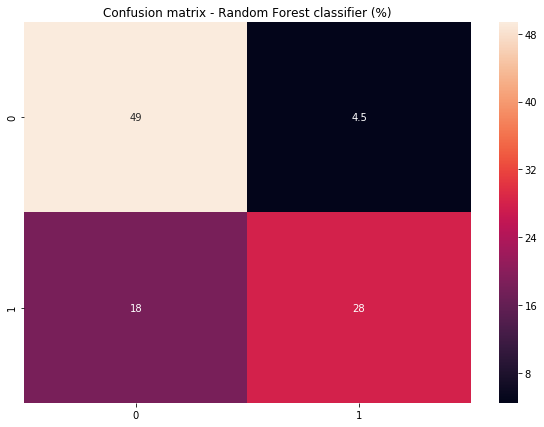

Step 2:
predicting class 1 or 2 within class 1


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


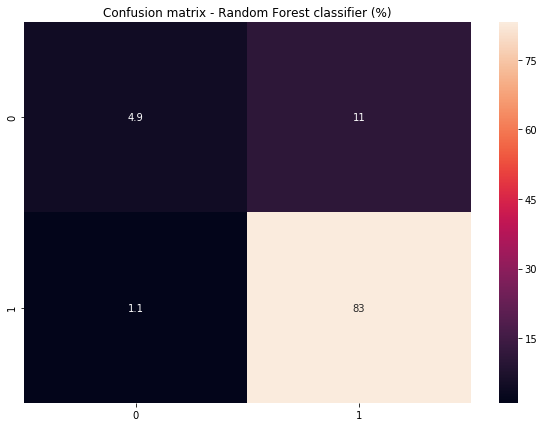

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/unbalanced_predictions.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_temp['Class 2'] = y2_score


Prediction process completed in 200.13 s

----
Initialisation - Gradient Boosting classifier
2 classes approach:
----
Step 1:
predicting class 0 and class 1 (i.e class 1 and 2)


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


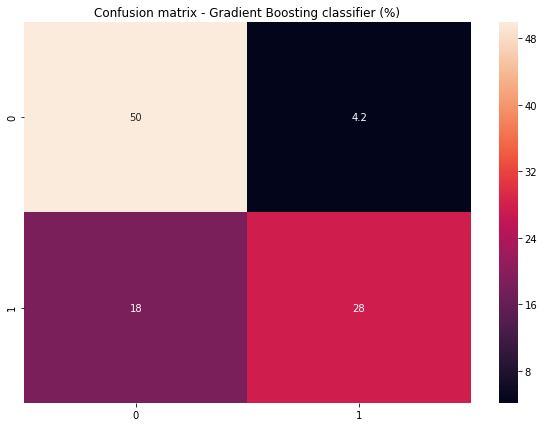

Step 2:
predicting class 1 or 2 within class 1


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


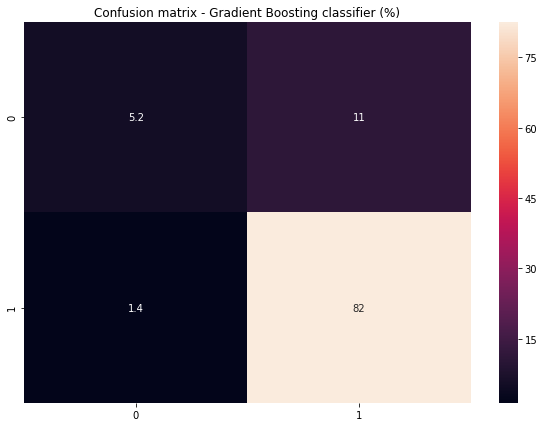

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/unbalanced_predictions.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_temp['Class 2'] = y2_score


Prediction process completed in 196.89 s

----
Initialisation - XGBoost classifier
2 classes approach:
----
Step 1:
predicting class 0 and class 1 (i.e class 1 and 2)


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


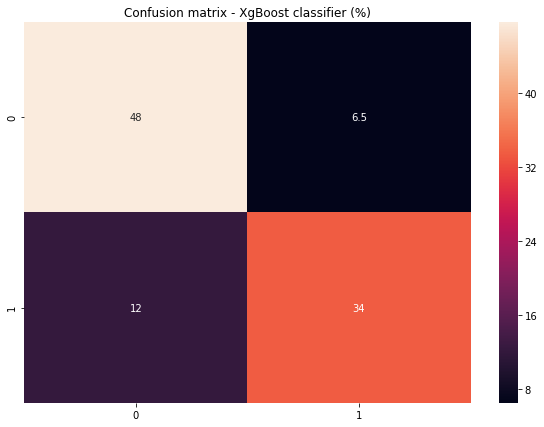

Step 2:
predicting class 1 or 2 within class 1


/Users/louisgiron/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:261: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all([l not in y_true for l in labels]):


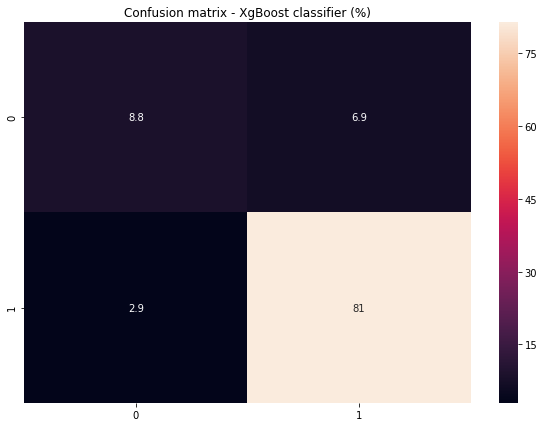

/Users/louisgiron/Desktop/ENSAE - Mastère spé/Machine Learning/projet_ml/codes/unbalanced_predictions.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_temp['Class 2'] = y2_score


Prediction process completed in 1330.7 s

Execution time: 28.95 min

Score Arbre de décision:  0.886969696969697
Score RandomForest:  0.9115656565656566
Score GradientBoosting:  0.9143939393939394
Score XGBoost:  0.9377104377104377


In [44]:
# Predict with the SMOTE method
# time
start = time.time()

# Arbre de décision
print('----')
print('Initialisation - Decision Tree classifier')
substart = time.time()
ArbreDecision = unbalancedPrediction(X, y, submit, 'ArbreDecision', variables_selected)
ArbreDecision_pred = ArbreDecision.processDataPredicted()
subexec_time = np.round(time.time() - substart, 2)
print('Prediction process completed in', subexec_time, 's')
print()

# RandomForest
print('----')
print('Initialisation - Random Forest classifier')
substart = time.time()
RandomForest = unbalancedPrediction(X, y, submit, 'RandomForest', variables_selected) 
RandomForest_pred = RandomForest.processDataPredicted()
subexec_time = np.round(time.time() - substart, 2)
print('Prediction process completed in', subexec_time, 's')
print()

# GradientBoosting
print('----')
print('Initialisation - Gradient Boosting classifier')
substart = time.time()
GradientBoosting = unbalancedPrediction(X, y, submit, 'GradientBoosting', variables_selected)
GradientBoosting_pred = GradientBoosting.processDataPredicted()
subexec_time = np.round(time.time() - substart, 2)
print('Prediction process completed in', subexec_time, 's')
print()

# XGBoost
print('----')
print('Initialisation - XGBoost classifier')
substart = time.time()
XGBoost = unbalancedPrediction(X, y, submit, 'XgBoost', variables_selected)
XGBoost_pred = XGBoost.processDataPredicted()
subexec_time = np.round(time.time() - substart, 2)
print('Prediction process completed in', subexec_time, 's')
print()

# Execution time
exec_time = np.round((time.time() - start)/60, 2)
print('Execution time:', exec_time, 'min')
print()

# Score
print('Score Arbre de décision: ', ArbreDecision_pred[1])
print('Score RandomForest: ', RandomForest_pred[1])
print('Score GradientBoosting: ', GradientBoosting_pred[1])
print('Score XGBoost: ', XGBoost_pred[1])

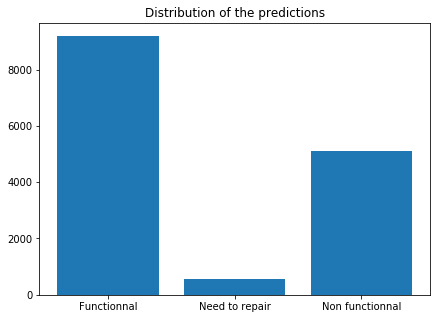

In [45]:
# Distribution of the predictions of the best predictor
pred = XGBoost_pred[0]
pred = [np.sum(pred==0), np.sum(pred==1), np.sum(pred==2)]
labels = ['Functionnal', 'Need to repair', 'Non functionnal']
plt.figure(figsize=(7, 5))
plt.bar(np.arange(0, 3), pred)
plt.xticks(np.arange(0, 3), labels)
plt.title('Distribution of the predictions')
plt.show()

### Submissions

In [47]:
# XGBoost
to_submit = pd.DataFrame()
to_submit['id'] = X_submit['id']
to_submit['status_group'] = code.inverse_transform(XGBoost_pred[0])
# CSV
to_submit.to_csv(path_submit + '/Submissions_xgboost_smote.csv', sep=",",
                 header=True, index=False)

# VI - Recommendation